In [1]:
import torch
from torch import nn,optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms, models
from transformers import BertModel, BertConfig,AutoModel

import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from UMPC_Dataset import UMPC_FoodDataset

/home/shayulong/miniconda3/envs/fl/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import requests
from requests.packages.urllib3.exceptions import InsecureRequestWarning
url = "https://api.easypost.com/something"
returnResponse = requests.get(url, verify=False)
requests.packages.urllib3.disable_warnings(InsecureRequestWarning)
os.environ['CURL_CA_BUNDLE'] = ''
import warnings
warnings.filterwarnings("ignore") 

a=15
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
random.seed(a)
np.random.seed(a)
torch.manual_seed(a)
torch.cuda.manual_seed(a)

/home/shayulong/miniconda3/envs/fl/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.easypost.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [3]:
OUTPUT_SIZE =101
epochs=15
batch_size=10
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
tf = transforms.Compose([transforms.Resize((224,224)),
                                # transforms.CenterCrop(resize),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                    [0.229, 0.224, 0.225])])
Train_set=UMPC_FoodDataset(targ_dir="./data/food" ,phase="train", mode="all",transform=tf)
Test_set=UMPC_FoodDataset(targ_dir="./data/food" ,phase="test", mode="all",transform=tf)
Trainloader = DataLoader(Train_set, batch_size=batch_size, shuffle=False,num_workers=16)
Testloader = DataLoader(Test_set, batch_size=batch_size, shuffle=False,num_workers=16)

In [5]:
print(f"Train samples num: {len(Train_set)}")
print(f"Train samples num: {len(Test_set)}")
print(f"Total no. of batches in testloader : {len(Testloader)}")

Train samples num: 67971
Train samples num: 22715
Total no. of batches in testloader : 2272


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image shape: torch.Size([3, 224, 224])
Image datatype: torch.float32 

torch.Size([40])
torch.Size([40])
torch.Size([40])
{'input_ids': tensor([  101, 14124,  2139, 12909, 20677,  1024,  6207, 11345,  2013, 11969,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}


Text(0.5, 1.0, 'Class: 0 : apple_pie')

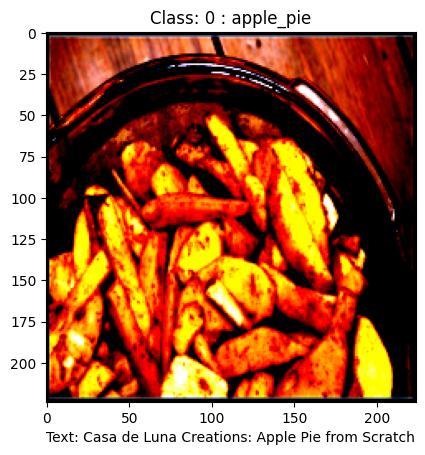

In [6]:
sample=Test_set[0]
img,txt_tokens,txt,lbl=sample
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype} \n")
print(txt_tokens['input_ids'].shape)
print(txt_tokens['token_type_ids'].shape)
print(txt_tokens['attention_mask'].shape)
print(txt_tokens)
figure, ax = plt.subplots()
ax.imshow(sample[0].permute(1,2,0))
ax.set_xlabel(f"Text: {sample[2]}",fontsize=10)
ax.set_title(f"Class: {lbl} : {Test_set.idx_to_class[sample[3]]}")

In [11]:
import torch
from torch.utils.data import DataLoader, Subset, Dataset
import numpy as np
import random
from sklearn.model_selection import train_test_split

class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        modality1, modality2, label = self.data[index]
        if modality1 is None:
            modality1 = torch.zeros(3, 224, 224)
        if modality2 is None:
            modality2 = {
                'input_ids': torch.zeros((40,), dtype=torch.long),
                'token_type_ids': torch.zeros((40,), dtype=torch.long),
                'attention_mask': torch.zeros((40,), dtype=torch.long)
            }
        return modality1, modality2, label

# 定义函数用于创建IID或Non-IID数据分布
def federated_split(dataset, num_clients=20, alpha=None):
    total_len = len(dataset)
    indices = list(range(total_len))
    random.shuffle(indices)

    if alpha:
        labels = [label for _, _, _, label in dataset]
        n_classes = len(set(labels))
        label_to_indices = {label: np.where(np.array(labels) == label)[0] for label in range(n_classes)}
        
        per_client_probs = np.random.dirichlet([alpha]*n_classes, num_clients)
        client_indices = [[] for _ in range(num_clients)]
        for c, probs in enumerate(per_client_probs):
            for label, prob in enumerate(probs):
                indices = label_to_indices[label]
                client_label_indices = np.random.choice(indices, int(prob * len(indices)), replace=False)
                client_indices[c].extend(client_label_indices)
                label_to_indices[label] = np.setdiff1d(label_to_indices[label], client_label_indices)
    else:
        per_client = total_len // num_clients
        client_indices = [indices[i * per_client:(i + 1) * per_client] for i in range(num_clients)]

    # 将数据处理移到循环外
    preprocessed_data = [(x[0], x[1], x[3]) for x in dataset]
    client_datasets = []
    for i, indices in enumerate(client_indices):
        client_data = [preprocessed_data[idx] for idx in indices]
        if i < 8:
            client_data = [(x[0], None, x[2]) for x in client_data]
        elif 8 <= i < 16:
            client_data = [(None, x[1], x[2]) for x in client_data]
        client_datasets.append(CustomDataset(client_data))

    return client_datasets


# 使用这些函数
# 假设 Train_set 是原始训练数据集
client_datasets_iid = federated_split(Train_set, num_clients=20, alpha=None)
print('here')
torch.save(client_datasets_iid, 'client_datasets_iid.pt')
client_datasets_noniid = federated_split(Train_set, num_clients=20, alpha=0.5)
print('here')
torch.save(client_datasets_noniid, 'client_datasets_noniid_0.5.pt')
# 创建每个客户端的 DataLoader
user_dataloaders_iid = [DataLoader(dataset, batch_size=100, num_workers=16, shuffle=True) for dataset in client_datasets_iid]
user_dataloaders_noniid = [DataLoader(dataset, batch_size=100, num_workers=16, shuffle=True) for dataset in client_datasets_noniid]


here
here


In [ ]:
class TextModel(nn.Module):
    def __init__(self, dim_text_repr=768, num_class=101):
        super().__init__()
        config = BertConfig()
        self.textEncoder= BertModel(config).from_pretrained('bert-base-uncased')    
        self.linear = nn.Linear(dim_text_repr, num_class)

    def forward(self, x):
        text = x
        hidden_states = self.textEncoder(**text)  # B, T, dim_text_repr
        e_i = F.dropout(hidden_states[1]) 
        return e_i
    
text_model = TextModel(num_class=OUTPUT_SIZE).to(device)
text_model.load_state_dict(torch.load("./Saved_weights/BERT_UMPC_best_weights.pt"))